# Week 4: Visualizing Data

## Clear the entire workspace

In [1]:
rm(list = ls())

## Load libraries

In [3]:
ReqdLibs = c("readxl","ggplot2","ggthemes","dplyr","tidyr","forcats","janitor","IRdisplay")

invisible(lapply(ReqdLibs, library, character.only = TRUE))

# A. The Anatomy of a GGPLOT

![Image Description](imgs/0.png)

*Image Source*: https://ggplot2.tidyverse.org/articles/ggplot2.html

## The Data
This is the foundation of the your whole graphic edifice, which you define through the function `ggplot()`. <br>Make sure it is not wrong (or absent!)


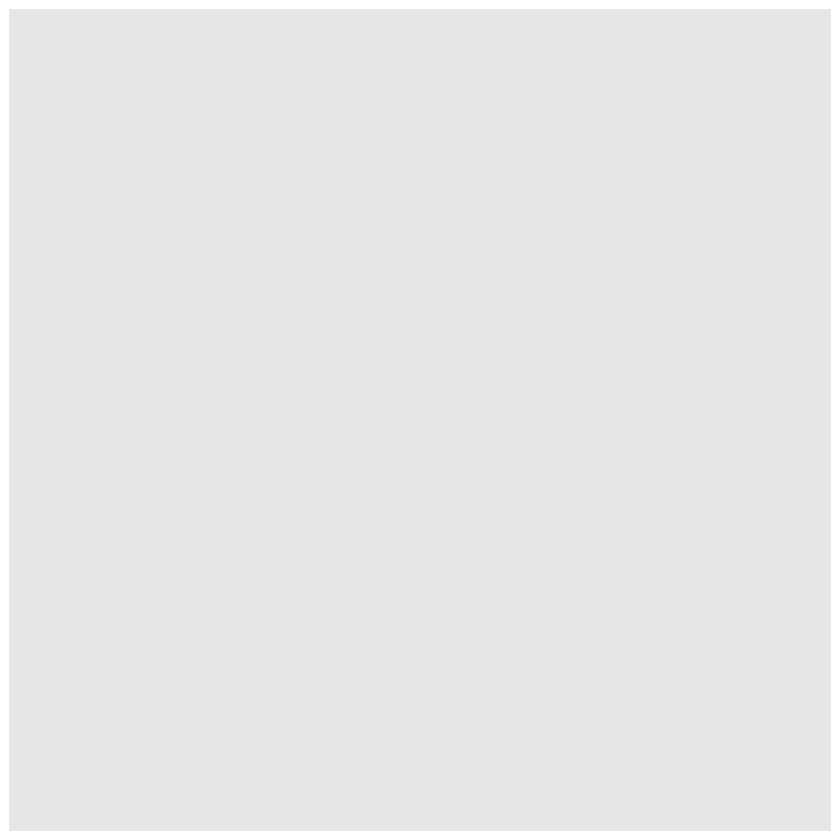

In [4]:
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(data = mpg)

## The Mapping
This is where you define the fundamental descriptors of the graph through the function `aes()`. <br> What you define here are <u>the elements of your graph</u> and those elements are directly linked to **the number of information carrying dimensions of your data** (*Tufte, Chap. 2*, Visual Display of Quantitative Information, $2^{nd}$ Ed).

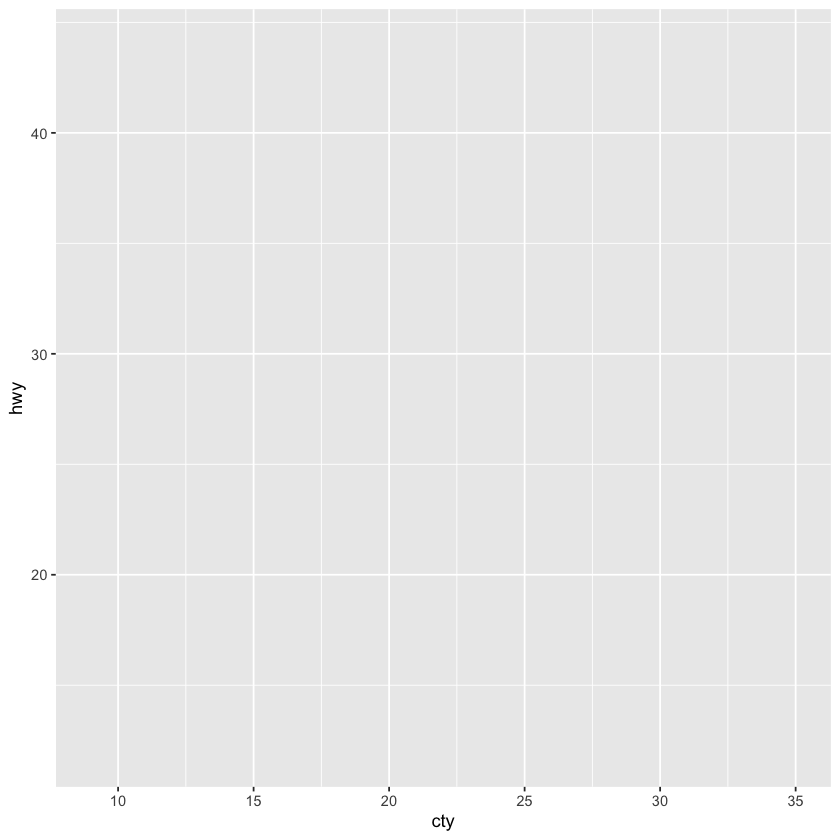

In [5]:
ggplot(mpg, mapping = aes(x = cty, y = hwy))

## The Layers
This is where you define the geometric, statistical, or positional elements of the data through the `geom_*()`, `stat_*()`, or `position_*` function respectively.<br>
This is where all the action happens and something actually appears on your plot!

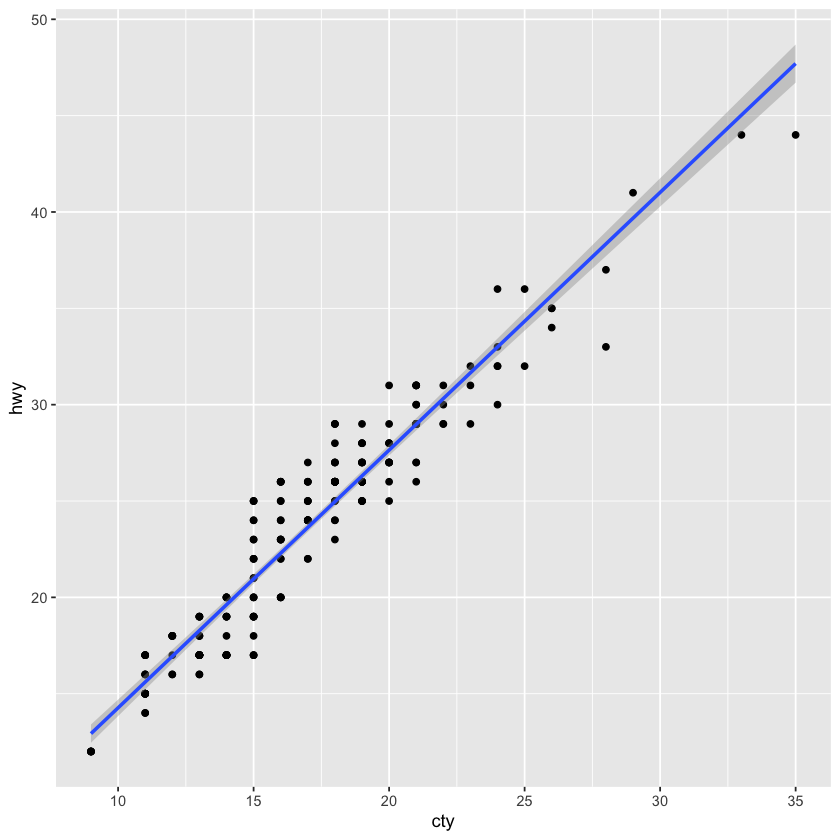

In [7]:
ggplot(mpg, aes(cty, hwy)) +
  # to create a scatterplot
  geom_point() +
  # to fit and overlay a loess trendline
  geom_smooth(formula = y ~ x, method = "lm")

## Enhancements
### Scales

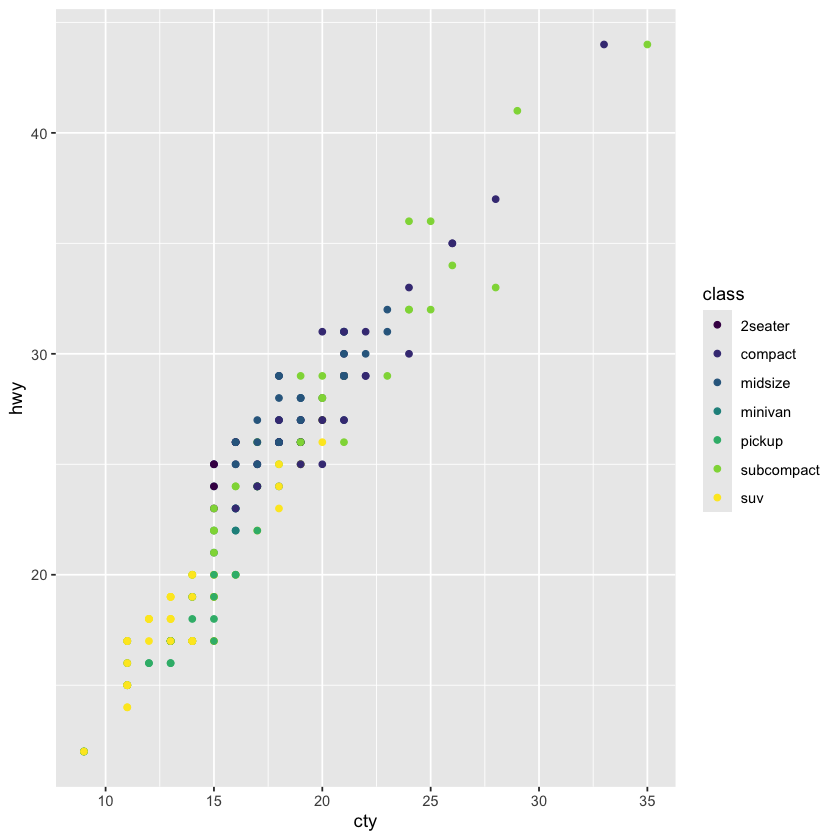

In [8]:
ggplot(mpg, aes(cty, hwy, colour = class)) +
  geom_point() +
  scale_colour_viridis_d()

### Facets

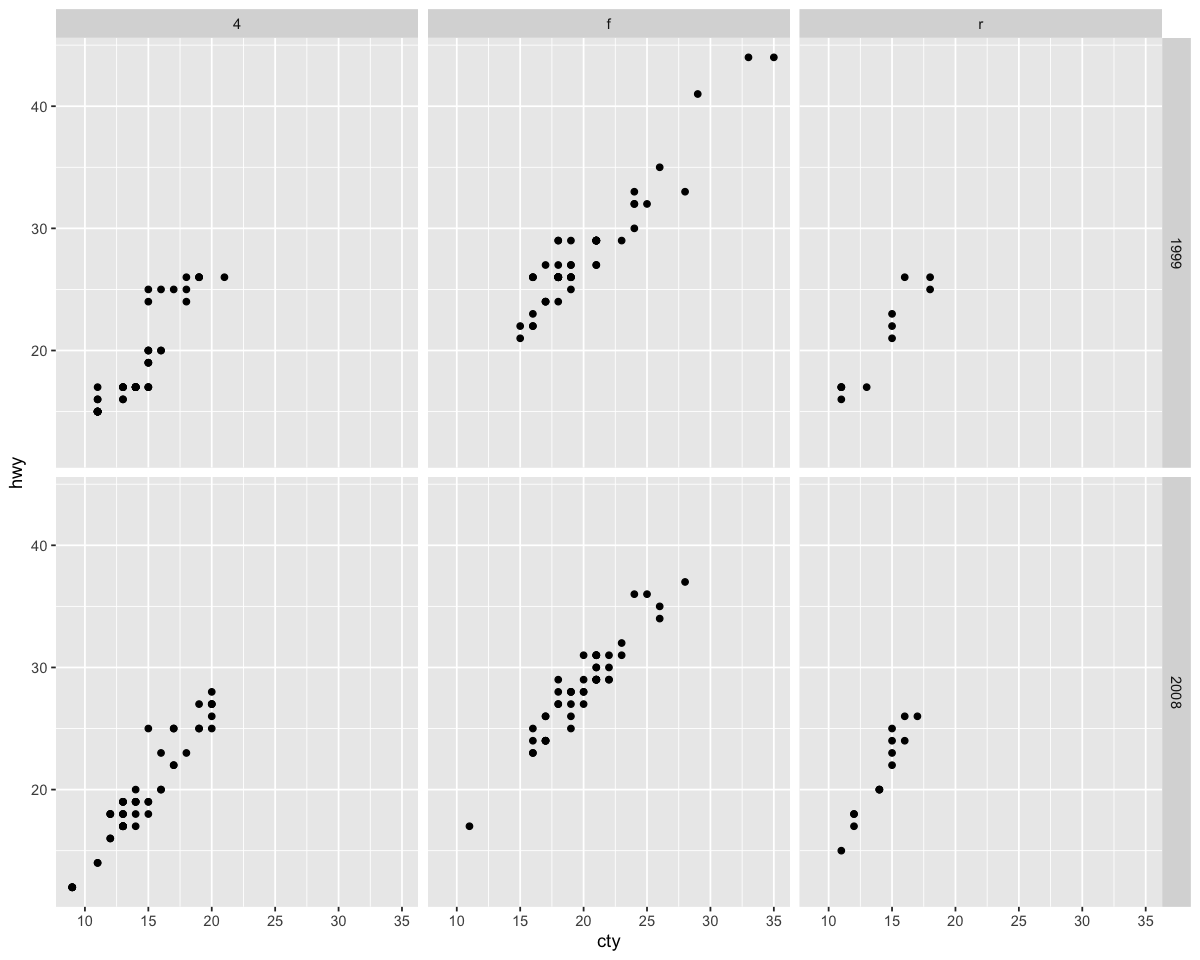

In [9]:
options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(mpg, aes(cty, hwy)) +
  geom_point() +
  facet_grid(year ~ drv)

### Coordinates

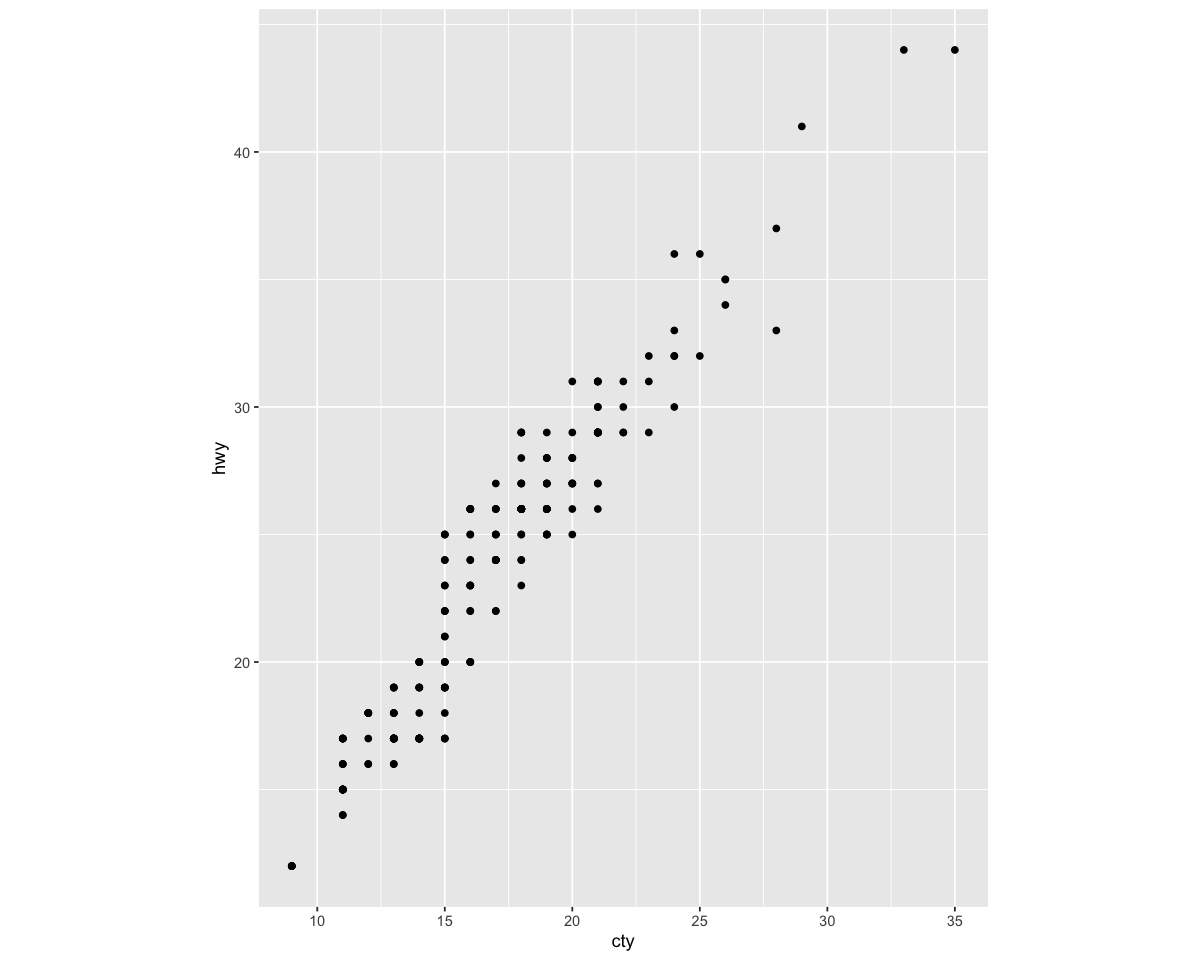

In [10]:
ggplot(mpg, aes(cty, hwy)) +
  geom_point() +
  coord_fixed()

### Theme

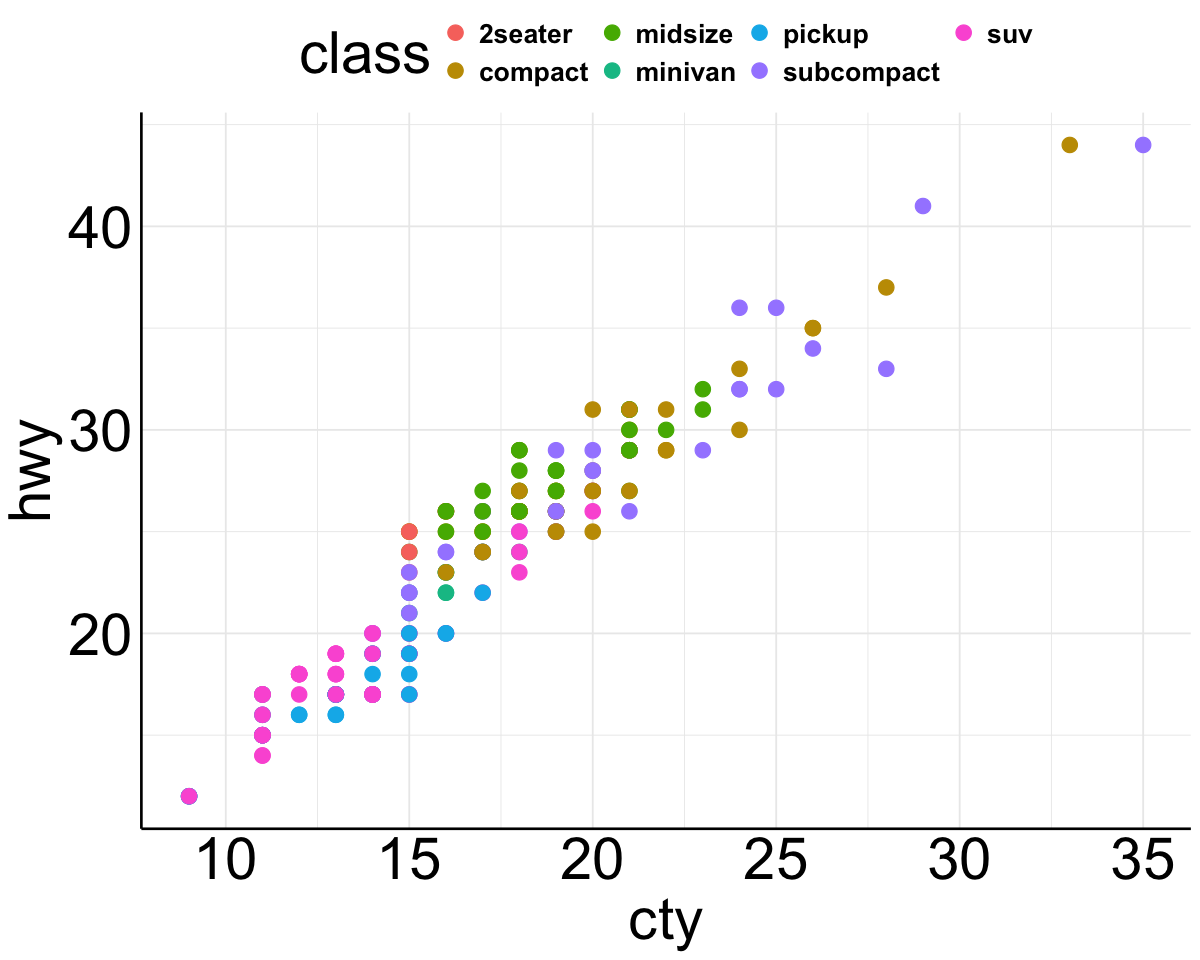

In [11]:
ggplot(mpg, aes(cty, hwy, colour = class)) +
  geom_point(size = 4) +
  theme_minimal() + 
  theme(
    legend.position = "top",
    legend.text=element_text(size=16,face="bold"),
    axis.line = element_line(linewidth = 0.75),
    axis.text = element_text(colour = "black",size=35),
    text = element_text(colour = "black",size=35)    
  )


## All together

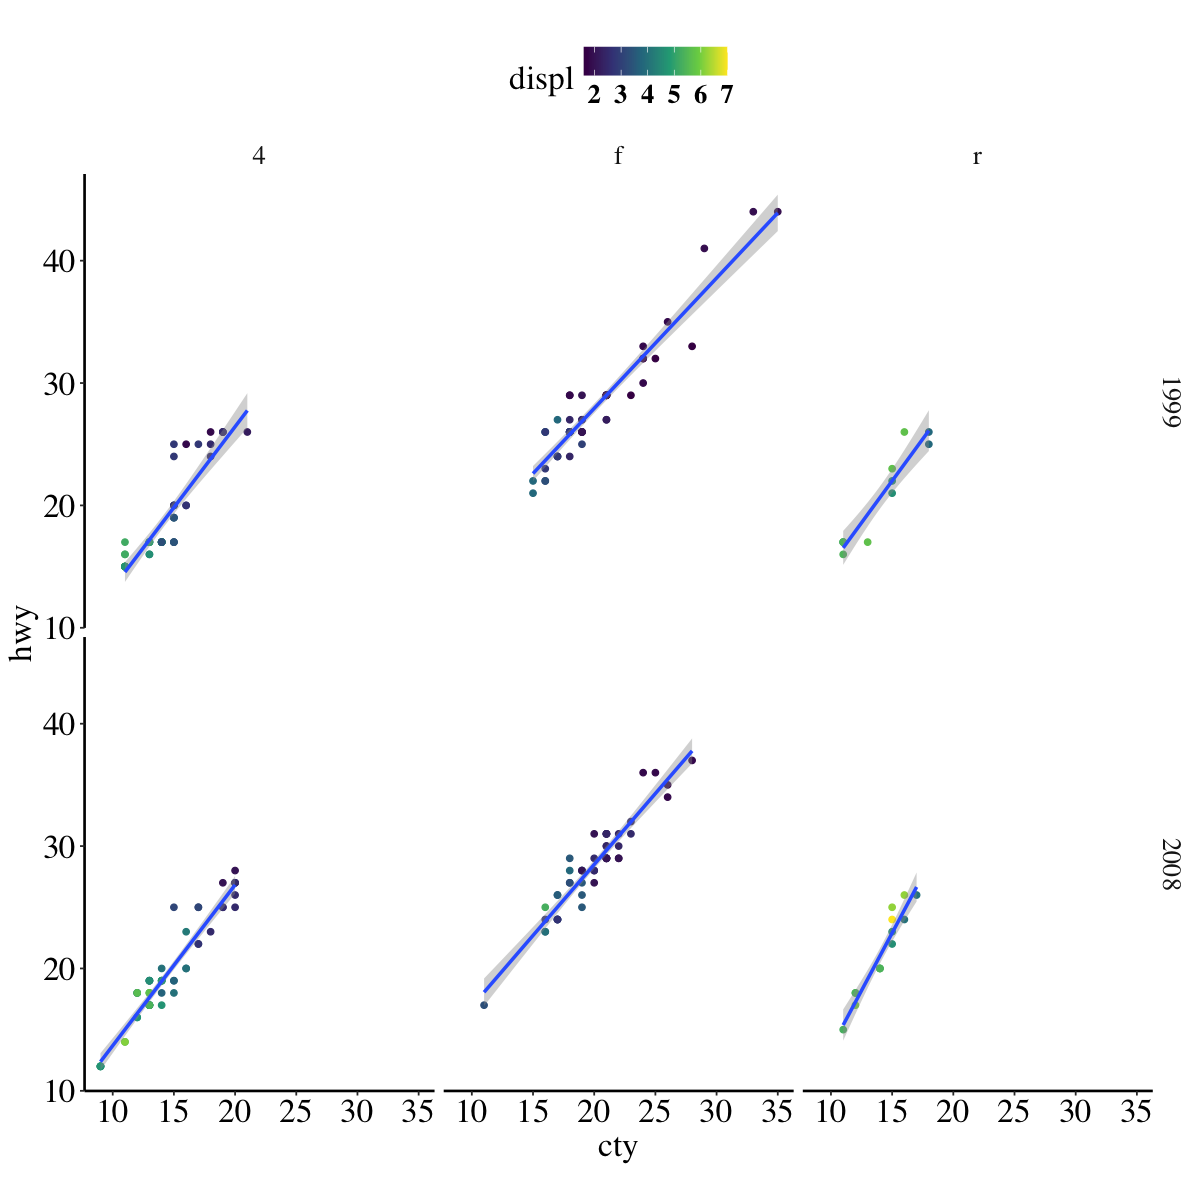

In [12]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggplot(mpg, aes(cty, hwy)) +
  geom_point(mapping = aes(colour = displ)) +
  geom_smooth(formula = y ~ x, method = "lm") +
  scale_colour_viridis_c() +
  facet_grid(year ~ drv) +
  coord_fixed() +
  theme_tufte() +
  theme(
    legend.position = "top",
    legend.text=element_text(size=16,face="bold"),
    axis.line = element_line(linewidth = 0.75),
    axis.text = element_text(colour = "black",size=20),
    text = element_text(colour = "black",size=20)    
  )

# B. Reproducing a figure using GGPLOT

## Import data

In [13]:
dat.raw = read.csv(file = "rawdata.csv", header = TRUE)
head(dat.raw)
dim(dat.raw)

,X,t,R,VT,VE,VO2,Sub,trial
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,1,2,0.9855204,0.7548531,13.97876,408.6987,Sub1,rest
2,2,5,0.9628962,0.5538989,11.62026,304.7868,Sub1,rest
3,3,8,0.9976182,0.7058896,12.87337,347.7043,Sub1,rest
4,4,10,0.9754142,0.7823950,19.97604,614.8135,Sub1,rest
5,5,13,0.9758078,0.4957548,10.89571,253.6431,Sub1,rest
6,6,16,0.9630747,0.7874953,14.90527,437.0967,Sub1,rest


[1] 15062     8

## Transform data

### Reordering `Sub` factor
so that it is sorted numerically rather than alphabetically

In [14]:
# reorder the Sub factor so that it is sorted numerically rather than alphabetically

# fct_reorder is in the forcats package which does not rely on 'exact' names for reordering
# gsub or global substitution funcn that looks for a specific text pattern (regex) and replaces it 
# (kind of like ctrl F & replace)
dat.raw$Sub <- fct_reorder(dat.raw$Sub, as.numeric(gsub("Sub", "", dat.raw$Sub)))
levels(dat.raw$Sub)

[1] "Sub1"  "Sub2"  "Sub3"  "Sub4"  "Sub5"  "Sub6"  "Sub7"  "Sub8"  "Sub9" 
[10] "Sub10" "Sub11" "Sub12" "Sub13"

### Trial = experimental manipulations!
All participants did 1 single `trial` walking under different conditions. Hence, we have 6 trials + rest.<br>
_**But**_, `trial` as a variable is pretty uninformative. We want to understand what these trials mean so that we can plot how some response, _**y**_ ($VO_{2}$ etc) changed as a result of the independently manipulated variable, _**x**_ (incline or speed).

![Image Description](imgs/1.png)


In [15]:
# based on above, we define trial number (conditions) that match the incline and speeds
# these are 'condition sets' which we will call when we apply conditional logics next.

# inclines
lev = c("1","2")
uph = c("3","4")
dwh = c("5","6")

# speeds
fs = c("1","3","5")
sl = c("2","4","6")


In [16]:
dat.raw %>% 
# so we can refer to those trial conditions more succinctly 
# let's separate these characters into workable parts
separate(trial,into=c("prefix","num"), sep = " ",fill="right",remove = FALSE) %>%  

# rest is coded differently from them, so we fill out the new variable type with "rest"
mutate(num = if_else(prefix == "rest", prefix, num)) %>% 

# now we are ready to define some new informative variables from our non-informative variable "type"
mutate(cond = if_else(num == "rest", num, "walk"),
       
       incline = case_when(num %in% lev ~ "level",
                           num %in% uph ~ "uphill",
                           num %in% dwh ~ "downhill",
                           num == "rest" ~ "rest",
                           TRUE ~ NA_character_),
       
       speed = case_when(num %in% fs ~ 1.3,
                         num %in% sl ~ 0.8,
                         cond == "rest" ~ 0,
                           TRUE ~ NA_real_)) %>% 
# remove unwanted variables
select(!c("X","prefix","num")) %>% 

# assign to a new 'defined' data frame
{.->> dat.def}

tail(dat.def)


,t,R,VT,VE,VO2,Sub,trial,cond,incline,speed
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<dbl>
15057,426,0.8729754,0.6416436,14.473163,509.72379,Sub9,trial 6,walk,downhill,0.8
15058,429,0.9632060,0.5324928,11.055213,361.50629,Sub9,trial 6,walk,downhill,0.8
15059,431,0.9126303,0.8946287,23.963267,873.85555,Sub9,trial 6,walk,downhill,0.8
15060,434,0.8497735,0.5273923,14.582274,494.51991,Sub9,trial 6,walk,downhill,0.8
15061,435,0.8142049,0.4304827,14.675545,394.51961,Sub9,trial 6,walk,downhill,0.8
15062,437,0.4978951,0.1407739,4.590455,35.72638,Sub9,trial 6,walk,downhill,0.8


### Trimming time `t`
From the Koelewijn et al paper: "The first 30 seconds of the resting trial, and the first three minutes of each walking trial were disregarded. The rate of oxygen consumption, $VO_{2}$ in mL/min/kg, and respiratory quotient, $R$ were averaged over time."

In [17]:
rmv.rest = 30
rmv.walk = 3*60

dat.def %>% 
filter(case_when(cond == "rest" ~ t > rmv.rest,
                 cond == "walk" ~ t > rmv.walk,
                 TRUE ~ FALSE)) %>% 
group_by(Sub,cond,incline,speed) %>% 
summarize_if(is.double, ~ mean(., na.rm = TRUE)) %>% 

{.->>dat.summ}

head(dat.summ,7)

Sub,cond,incline,speed,R,VT,VE,VO2
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sub1,rest,rest,0.0,1.0537845,0.7031141,12.16978,328.9456
Sub1,walk,downhill,0.8,0.9019424,0.7859465,20.33910,728.5032
Sub1,walk,downhill,1.3,0.8661119,0.8409442,25.83893,1005.2468
Sub1,walk,level,0.8,0.8727268,1.0036957,26.00091,992.9288
Sub1,walk,level,1.3,0.8340541,1.0104406,32.61279,1368.0726
Sub1,walk,uphill,0.8,0.8661413,1.2505480,40.73454,1687.3811
Sub1,walk,uphill,1.3,0.8315770,1.4630620,58.84244,2540.5691


### Calculating new variables, $W$ & $C_{meas}$
...from constants and measured variables

![Image Description](imgs/2.png)


In [18]:
# VO2 in our data table is absolute VO2, to normalize it by the weight of each subject, 
# we need weight data from the demographic excel file!
# read excel file

demo=read_excel("SubjectInfo.xlsx")

tail(demo)

Subject No,Age,Reported Weight (kg),Reported Length (cm),Gender,Level Slow,Level Walk,Weight from force plates(kg)
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Sub8,21,57,173,F,599.2760,596.3572,60.93951
Sub9,25,58,170,M,575.0346,587.3807,59.24645
Sub10,20,66,170,F,673.0147,675.1750,68.71507
Sub11,20,76,188,M,783.6798,783.4256,79.87285
Sub12,33,70,178,M,715.1903,715.5865,72.92440
Sub13,21,56,169,F,661.9267,658.0335,67.27626


In [20]:
# TIP! you could use clean_names function from the janitor package
# to clean var names so that they don't contain spaces and parentheses.. 
# also makes it easyt to use dplyr to mutate later #uncomment below

demo.clean = demo %>% clean_names()
dat.summdemo = merge(dat.summ,demo.clean,by.x = 'Sub', by.y = 'subject_no')

head(demo.clean)

subject_no,age,reported_weight_kg,reported_length_cm,gender,level_slow,level_walk,weight_from_force_plates_kg
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Sub1,26,86,185,M,885.5529,891.5307,90.57511
Sub2,28,77,178,F,767.7686,760.2377,77.88004
Sub3,21,52,170,M,530.6408,558.2018,55.49656
Sub4,25,73,168,M,NA,NA,NA
Sub5,34,86,173,M,878.6303,898.5188,90.57845
Sub6,19,54,160,F,553.4936,558.2845,56.66555


### ...after normalizing $VO_{2}$ by weight

In [21]:
dat.summdemo %>% 
mutate(adjVO2 = VO2/reported_weight_kg) %>% 
mutate(W = 4.184/60 * (3.972 + 1.078 * R) * adjVO2) %>% 
{.->>dat.calc1}

head(dat.calc1)

,Sub,cond,incline,speed,R,VT,VE,VO2,age,reported_weight_kg,reported_length_cm,gender,level_slow,level_walk,weight_from_force_plates_kg,adjVO2,W
,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Sub1,rest,rest,0.0,1.0537845,0.7031141,12.16978,328.9456,26,86,185,M,885.5529,891.5307,90.57511,3.824949,1.362433
2,Sub1,walk,downhill,0.8,0.9019424,0.7859465,20.33910,728.5032,26,86,185,M,885.5529,891.5307,90.57511,8.470967,2.920638
3,Sub1,walk,downhill,1.3,0.8661119,0.8409442,25.83893,1005.2468,26,86,185,M,885.5529,891.5307,90.57511,11.688916,3.998645
4,Sub1,walk,level,0.8,0.8727268,1.0036957,26.00091,992.9288,26,86,185,M,885.5529,891.5307,90.57511,11.545684,3.955388
5,Sub1,walk,level,1.3,0.8340541,1.0104406,32.61279,1368.0726,26,86,185,M,885.5529,891.5307,90.57511,15.907821,5.403549
6,Sub1,walk,uphill,0.8,0.8661413,1.2505480,40.73454,1687.3811,26,86,185,M,885.5529,891.5307,90.57511,19.620710,6.712065


### Now calculating $C_{meas}$  :
From the Koelewijn et al paper: "The resting trial was subtracted from each walking trial. The metabolic rate was divided by walking speed to find the measured metabolic cost in J/kg/m:"

![Image Description](imgs/3.png)


In [22]:
# extracting the rest trials only so we can merge it as a column next
dat.calc1 %>% 
filter(cond=="rest") %>% 
select(Sub,W) %>% 
{.->>dat.rest}

# now merging it with the original 
merge(dat.calc1,dat.rest,by='Sub',suffixes = c('','_rest')) %>% 
filter(cond!="rest") %>% 
mutate(W_adj = W - W_rest) %>% 
mutate(C_meas = W_adj/speed) %>% 
{.->>dat.calc2}

head(dat.calc2)

,Sub,cond,incline,speed,R,VT,VE,VO2,age,reported_weight_kg,reported_length_cm,gender,level_slow,level_walk,weight_from_force_plates_kg,adjVO2,W,W_rest,W_adj,C_meas
,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Sub1,walk,downhill,0.8,0.9019424,0.7859465,20.33910,728.5032,26,86,185,M,885.5529,891.5307,90.57511,8.470967,2.920638,1.362433,1.558204,1.947756
2,Sub1,walk,downhill,1.3,0.8661119,0.8409442,25.83893,1005.2468,26,86,185,M,885.5529,891.5307,90.57511,11.688916,3.998645,1.362433,2.636212,2.027855
3,Sub1,walk,level,1.3,0.8340541,1.0104406,32.61279,1368.0726,26,86,185,M,885.5529,891.5307,90.57511,15.907821,5.403549,1.362433,4.041116,3.108550
4,Sub1,walk,uphill,0.8,0.8661413,1.2505480,40.73454,1687.3811,26,86,185,M,885.5529,891.5307,90.57511,19.620710,6.712065,1.362433,5.349632,6.687040
5,Sub1,walk,uphill,1.3,0.8315770,1.4630620,58.84244,2540.5691,26,86,185,M,885.5529,891.5307,90.57511,29.541501,10.029119,1.362433,8.666686,6.666682
6,Sub1,walk,level,0.8,0.8727268,1.0036957,26.00091,992.9288,26,86,185,M,885.5529,891.5307,90.57511,11.545684,3.955388,1.362433,2.592955,3.241194


## Visualizing metabolic cost $C_{meas}$ 
Finally after all that we have the variable we want to plot. Let's now reproduce the bottom-right panel of Figure 5 from the paper. It's shown below for reference:<br>

![Image Description](imgs/4.png)


In [24]:
thm = theme(
          legend.text=element_text(size=16,face="bold"),
          legend.position = "top",
          legend.title=element_text(size=16,face="bold"),
          title =element_text(size=14, face='bold'),
          text = element_text(colour = "black",size=18), 
          plot.title = element_text(colour = "black",size = 35, face = "bold", hjust = 0.5),
          axis.ticks.length = unit(-0.3,"cm"),
          axis.line = element_line(colour = "black",size=1),
          axis.ticks = element_line(colour = "black",size=1),
          axis.text = element_text(colour = "black",size=35),
          axis.text.x = element_text(lineheight = 1.1, margin = margin(t = 20)),
          axis.title.y = element_text(size=35, colour = "grey35", face = "plain", 
                                     lineheight = 1.1, margin = margin(r = 10)))

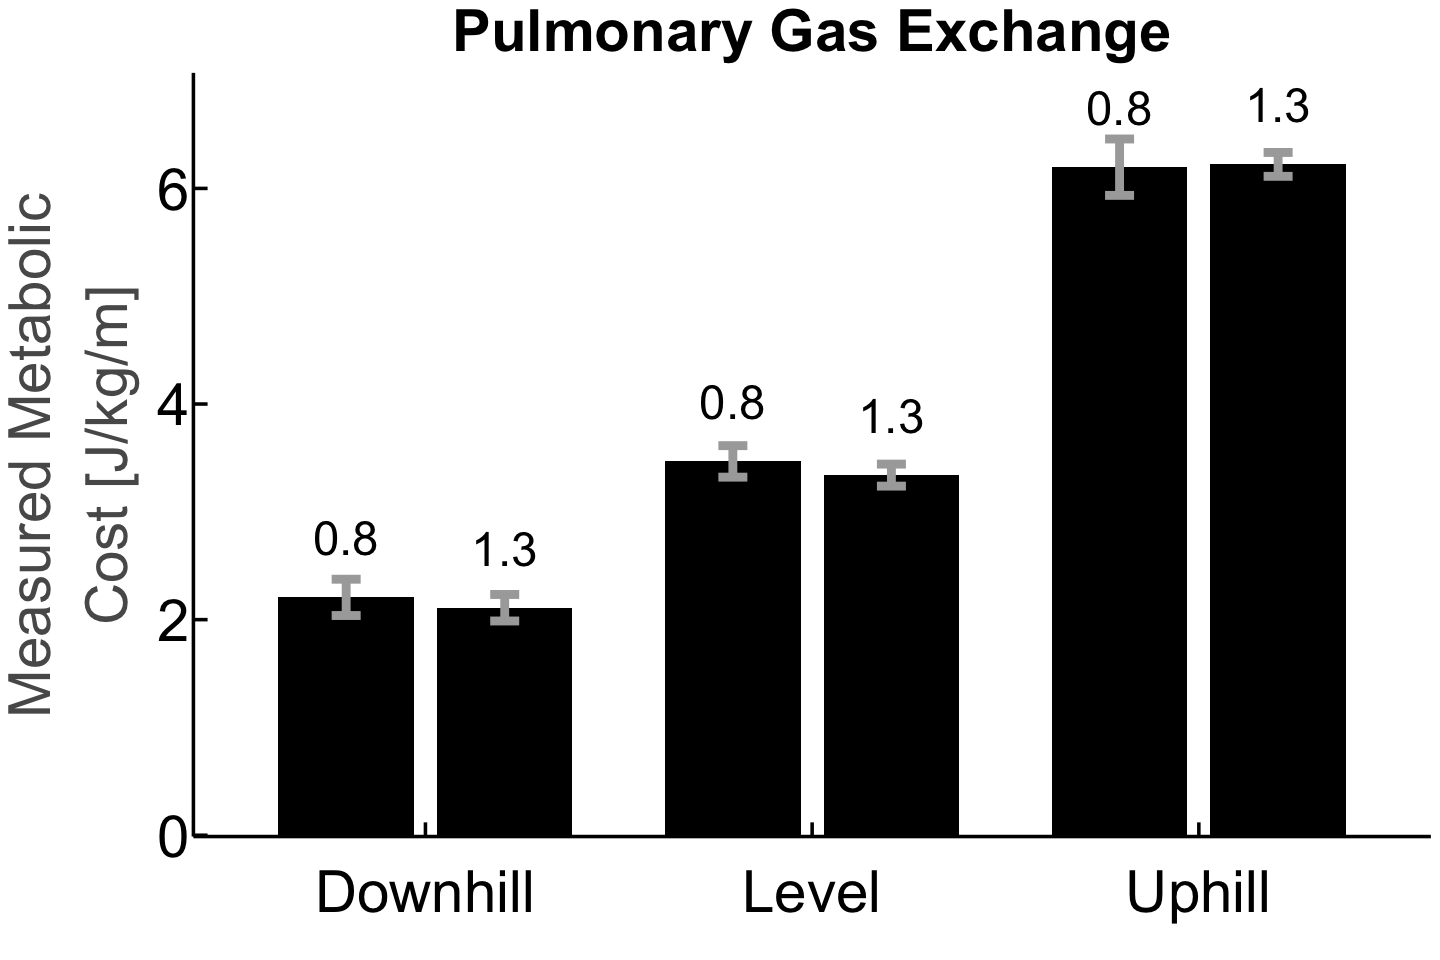

In [27]:
options(repr.plot.width = 12, repr.plot.height = 8)

repro.fig = 
# FUNCTION CALL
ggplot(dat.calc2, aes(x = incline,y = C_meas, group = speed, label = speed)) + 

# LAYERS THAT SUMMARIZE WHILE PLOTTING! - this is one of the most powerful features of ggplot
stat_summary(geom = "bar", fun.y = mean, col = NA, fill = "black", width = 0.7, na.rm = TRUE,
             position=position_dodge(width = 0.82, preserve = 'single')) + 
stat_summary(geom = "errorbar",fun.data = mean_se, width = 0.15, lwd=2.5, col="darkgray", na.rm = TRUE,
            position=position_dodge(0.82, preserve = 'single')) + 
stat_summary(geom = "text", fun.y = mean, position = position_dodge(0.82, preserve = 'total'), na.rm = TRUE,
             vjust = -1.25, size = 10) +

# AXIS LIMITS
coord_cartesian(ylim = c(0.31,6.75)) + 

# LABELS
scale_x_discrete(labels = c("Downhill", "Level", "Uphill")) +  # capitalize label initials :/
labs(title = "Pulmonary Gas Exchange", x = "", y = "Measured Metabolic\nCost [J/kg/m]") + 
theme_classic() + thm

repro.fig


#### Saving your graph

In [26]:
# saving your figures as image files
ggsave(file='reproduced_figure.svg', plot=repro.fig, width=12, height=8)

## Additional Resources
1) GGPLOT book: https://ggplot2-book.org/introduction.html#what-is-the-grammar-of-graphics
2) R Graphics Cookbook: https://r-graphics.org

<span style="color: #D80B77; font-size: 40px;">**Try it yourself!**</span>

1) Can you plot the graph above as a boxplot where the color is determined by `speed`?
   * What aspects of the graph would you be changing?
2) Can you overlay individual data points on top of that new boxplot?
3) Can you plot a scatterplot that shows `Age` on the x against metabolic cost `C_meas` on the y?
   * Then, facet it by `incline` and `speed`?


# The End